# Notebook 04: Pathway & Aging Hallmark Enrichment

**Kairos Therapeutics ML Prototype V0**

---

## Strategic Context

**Kairos is building a causal gene-intervention discovery engine for aging biology.**

- Aging is the root cause
- Diseases (OA, neurodegeneration, fibrosis) are manifestations
- Genes are controllable levers
- AI identifies which perturbations move aged/diseased systems toward youthful/healthy states

## Purpose of This Notebook

Bridge **disease biology → aging biology** by:
1. Mapping DE genes to MSigDB Hallmark pathways
2. Identifying enrichment in aging-relevant pathways
3. Explicit mapping to aging hallmarks (inflammation, senescence, proteostasis)
4. Framing outputs as **intervention opportunities** (what to up/downregulate)

## Inputs
- `data/processed/GSE114007_diff_expr_results.csv`
- `data/processed/GSE114007_significant_genes.csv`
- `data/processed/GSE114007_ranked_genes.csv`
- `h_all_v2025_1_Hs_symbols.gmt` (MSigDB Hallmarks)

## Outputs
- `data/processed/pathway_enrichment_results.csv`
- `data/processed/aging_hallmark_mapping.csv`
- `data/processed/intervention_candidates.csv`
- `reports/figures/pathway_enrichment_barplot.png`
- `reports/figures/aging_hallmark_heatmap.png`
- `reports/pathway_enrichment_summary.txt`

## Author
Pat Ovando-Roche, PhD | Kairos Therapeutics

## Version
v0.1 | December 2025

---
## Cell 1: Setup and Load Data

In [1]:
"""
CELL 1: SETUP AND LOAD DATA
===========================
Load DE results and pathway gene sets.
"""

import os
import warnings
from pathlib import Path
from datetime import datetime
from collections import defaultdict

warnings.filterwarnings('ignore')

# Core data science
import numpy as np
import pandas as pd

# Statistics
from scipy import stats
from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats.multitest import multipletests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# --- Determine paths ---
NOTEBOOK_DIR = Path(os.getcwd())
if NOTEBOOK_DIR.name == 'notebooks':
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
FIGURES_DIR = PROJECT_ROOT / 'reports' / 'figures'
REPORTS_DIR = PROJECT_ROOT / 'reports'

# Create output directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("NOTEBOOK 04: PATHWAY & AGING HALLMARK ENRICHMENT")
print("="*70)
print()
print("🎯 Strategic Frame: Disease dysregulation → Aging biology → Intervention targets")
print()
print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 Data folder: {DATA_PROCESSED}")
print()

# --- Load DE results ---
print("📥 Loading differential expression results...")
print()

try:
    de_results = pd.read_csv(DATA_PROCESSED / 'GSE114007_diff_expr_results.csv')
    print(f"   ✅ Full DE results: {de_results.shape}")
except FileNotFoundError:
    print("   ❌ DE results not found - run Notebook 03 first")
    de_results = None

try:
    sig_genes = pd.read_csv(DATA_PROCESSED / 'GSE114007_significant_genes.csv')
    print(f"   ✅ Significant genes: {sig_genes.shape}")
except FileNotFoundError:
    print("   ❌ Significant genes not found")
    sig_genes = None

try:
    ranked_genes = pd.read_csv(DATA_PROCESSED / 'GSE114007_ranked_genes.csv')
    print(f"   ✅ Ranked genes: {ranked_genes.shape}")
except FileNotFoundError:
    print("   ❌ Ranked genes not found")
    ranked_genes = None

print()
print(f"🕐 Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()
print("✅ Cell 1 complete. Ready for Cell 2.")

NOTEBOOK 04: PATHWAY & AGING HALLMARK ENRICHMENT

🎯 Strategic Frame: Disease dysregulation → Aging biology → Intervention targets

📁 Project root: C:\Users\povan\Kairos_Therapeutics
📁 Data folder: C:\Users\povan\Kairos_Therapeutics\data\processed

📥 Loading differential expression results...

   ✅ Full DE results: (23710, 13)
   ✅ Significant genes: (1269, 13)
   ✅ Ranked genes: (23710, 5)

🕐 Started: 2025-12-26 20:51:44

✅ Cell 1 complete. Ready for Cell 2.


---
## Cell 2: Load MSigDB Hallmarks Gene Sets

In [2]:
"""
CELL 2: LOAD MSIGDB HALLMARKS GENE SETS
=======================================
Parse the GMT file containing MSigDB Hallmark pathways.
"""

print("📚 LOADING MSIGDB HALLMARK GENE SETS")
print("="*70)
print()

def parse_gmt_file(gmt_path):
    """
    Parse a GMT file into a dictionary of gene sets.
    Format: pathway_name\turl\tgene1\tgene2\t...
    """
    gene_sets = {}
    with open(gmt_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            pathway_name = parts[0]
            # Skip URL (index 1), genes start at index 2
            genes = set(parts[2:])
            gene_sets[pathway_name] = genes
    return gene_sets

# Find GMT file - check multiple locations
gmt_locations = [
    PROJECT_ROOT / 'h_all_v2025_1_Hs_symbols.gmt',
    PROJECT_ROOT / 'data' / 'h_all_v2025_1_Hs_symbols.gmt',
    NOTEBOOK_DIR / 'h_all_v2025_1_Hs_symbols.gmt',
]

gmt_file = None
for loc in gmt_locations:
    if loc.exists():
        gmt_file = loc
        break

if gmt_file:
    print(f"   Found GMT file: {gmt_file}")
    hallmark_sets = parse_gmt_file(gmt_file)
    print(f"   ✅ Loaded {len(hallmark_sets)} Hallmark pathways")
    print()
    
    # Show pathway names (cleaned)
    print("   📋 Available Hallmarks:")
    for i, name in enumerate(sorted(hallmark_sets.keys())):
        clean_name = name.replace('HALLMARK_', '').replace('_', ' ').title()
        n_genes = len(hallmark_sets[name])
        if i < 10:
            print(f"      {i+1}. {clean_name} ({n_genes} genes)")
    print(f"      ... and {len(hallmark_sets) - 10} more")
else:
    print("   ⚠️ GMT file not found. Creating from scratch...")
    print("   Please ensure h_all_v2025_1_Hs_symbols.gmt is in the project root.")
    hallmark_sets = {}

print()
print("✅ Cell 2 complete. Ready for Cell 3.")

📚 LOADING MSIGDB HALLMARK GENE SETS

   Found GMT file: C:\Users\povan\Kairos_Therapeutics\h_all_v2025_1_Hs_symbols.gmt
   ✅ Loaded 50 Hallmark pathways

   📋 Available Hallmarks:
      1. Adipogenesis (200 genes)
      2. Allograft Rejection (200 genes)
      3. Androgen Response (101 genes)
      4. Angiogenesis (36 genes)
      5. Apical Junction (200 genes)
      6. Apical Surface (44 genes)
      7. Apoptosis (161 genes)
      8. Bile Acid Metabolism (112 genes)
      9. Cholesterol Homeostasis (74 genes)
      10. Coagulation (138 genes)
      ... and 40 more

✅ Cell 2 complete. Ready for Cell 3.


---
## Cell 3: Define Aging Hallmark Categories

In [3]:
"""
CELL 3: DEFINE AGING HALLMARK CATEGORIES
========================================
Map MSigDB Hallmarks to biological aging hallmarks.
This creates the bridge from disease biology to aging biology.

Reference: López-Otín et al. "Hallmarks of Aging" (Cell, 2013, 2023)
"""

print("🧬 DEFINING AGING HALLMARK CATEGORIES")
print("="*70)
print()

# Map MSigDB Hallmarks to Aging Hallmarks
# Key: Aging hallmark category
# Value: List of relevant MSigDB Hallmarks

AGING_HALLMARK_MAPPING = {
    'Chronic Inflammation (Inflammaging)': [
        'HALLMARK_INFLAMMATORY_RESPONSE',
        'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
        'HALLMARK_IL6_JAK_STAT3_SIGNALING',
        'HALLMARK_IL2_STAT5_SIGNALING',
        'HALLMARK_INTERFERON_GAMMA_RESPONSE',
        'HALLMARK_INTERFERON_ALPHA_RESPONSE',
        'HALLMARK_COMPLEMENT',
        'HALLMARK_ALLOGRAFT_REJECTION',
    ],
    'Loss of Proteostasis': [
        'HALLMARK_UNFOLDED_PROTEIN_RESPONSE',
        'HALLMARK_MTORC1_SIGNALING',
        'HALLMARK_PROTEIN_SECRETION',
    ],
    'Cellular Senescence': [
        'HALLMARK_P53_PATHWAY',
        'HALLMARK_APOPTOSIS',
        'HALLMARK_G2M_CHECKPOINT',
        'HALLMARK_E2F_TARGETS',
    ],
    'Mitochondrial Dysfunction': [
        'HALLMARK_OXIDATIVE_PHOSPHORYLATION',
        'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY',
        'HALLMARK_FATTY_ACID_METABOLISM',
    ],
    'ECM Degradation & Fibrosis': [
        'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
        'HALLMARK_TGF_BETA_SIGNALING',
        'HALLMARK_COAGULATION',
        'HALLMARK_ANGIOGENESIS',
    ],
    'Stem Cell Exhaustion': [
        'HALLMARK_WNT_BETA_CATENIN_SIGNALING',
        'HALLMARK_NOTCH_SIGNALING',
        'HALLMARK_HEDGEHOG_SIGNALING',
        'HALLMARK_MYOGENESIS',
    ],
    'Altered Metabolism': [
        'HALLMARK_GLYCOLYSIS',
        'HALLMARK_HYPOXIA',
        'HALLMARK_CHOLESTEROL_HOMEOSTASIS',
        'HALLMARK_ADIPOGENESIS',
    ],
    'Growth Factor Signaling': [
        'HALLMARK_PI3K_AKT_MTOR_SIGNALING',
        'HALLMARK_KRAS_SIGNALING_UP',
        'HALLMARK_KRAS_SIGNALING_DN',
    ],
}

# Print mapping
print("   📋 Aging Hallmark → MSigDB Pathway Mapping:")
print()
for aging_hallmark, pathways in AGING_HALLMARK_MAPPING.items():
    print(f"   🔹 {aging_hallmark}")
    for p in pathways:
        clean_name = p.replace('HALLMARK_', '').replace('_', ' ').title()
        if p in hallmark_sets:
            print(f"      • {clean_name} ({len(hallmark_sets[p])} genes)")
        else:
            print(f"      • {clean_name} (not found in GMT)")
    print()

print("✅ Cell 3 complete. Ready for Cell 4.")

🧬 DEFINING AGING HALLMARK CATEGORIES

   📋 Aging Hallmark → MSigDB Pathway Mapping:

   🔹 Chronic Inflammation (Inflammaging)
      • Inflammatory Response (200 genes)
      • Tnfa Signaling Via Nfkb (200 genes)
      • Il6 Jak Stat3 Signaling (87 genes)
      • Il2 Stat5 Signaling (199 genes)
      • Interferon Gamma Response (200 genes)
      • Interferon Alpha Response (97 genes)
      • Complement (200 genes)
      • Allograft Rejection (200 genes)

   🔹 Loss of Proteostasis
      • Unfolded Protein Response (113 genes)
      • Mtorc1 Signaling (200 genes)
      • Protein Secretion (96 genes)

   🔹 Cellular Senescence
      • P53 Pathway (200 genes)
      • Apoptosis (161 genes)
      • G2M Checkpoint (200 genes)
      • E2F Targets (200 genes)

   🔹 Mitochondrial Dysfunction
      • Oxidative Phosphorylation (200 genes)
      • Reactive Oxygen Species Pathway (49 genes)
      • Fatty Acid Metabolism (158 genes)

   🔹 ECM Degradation & Fibrosis
      • Epithelial Mesenchymal Transi

---
## Cell 4: Hypergeometric Enrichment Analysis

In [4]:
"""
CELL 4: HYPERGEOMETRIC ENRICHMENT ANALYSIS
==========================================
Test which pathways are enriched in:
1. All significant DE genes
2. Upregulated genes (potential targets to INHIBIT)
3. Downregulated genes (potential targets to RESTORE)

Intervention framing:
- Upregulated in disease → Consider inhibiting
- Downregulated in disease → Consider restoring/activating
"""

print("📊 PATHWAY ENRICHMENT ANALYSIS")
print("="*70)
print()
print("🎯 Intervention Framing:")
print("   • Pathways UP in OA → Disease drivers → Consider INHIBITING")
print("   • Pathways DOWN in OA → Protective loss → Consider RESTORING")
print()

def hypergeometric_enrichment(gene_list, gene_set, background_size):
    """
    Perform hypergeometric test for pathway enrichment.
    
    Parameters:
    - gene_list: set of genes of interest (e.g., DE genes)
    - gene_set: set of genes in pathway
    - background_size: total number of genes tested
    
    Returns:
    - overlap: number of genes in both
    - p_value: hypergeometric p-value
    - fold_enrichment: observed/expected ratio
    """
    gene_list = set(gene_list)
    gene_set = set(gene_set)
    
    overlap = gene_list & gene_set
    n_overlap = len(overlap)
    
    # Hypergeometric parameters
    M = background_size  # population size
    n = len(gene_set)    # successes in population
    N = len(gene_list)   # sample size
    k = n_overlap        # successes in sample
    
    # P-value: P(X >= k)
    p_value = hypergeom.sf(k - 1, M, n, N)
    
    # Fold enrichment
    expected = (n * N) / M
    fold_enrichment = n_overlap / expected if expected > 0 else 0
    
    return n_overlap, p_value, fold_enrichment, overlap

# Prepare gene lists
if de_results is not None and sig_genes is not None:
    all_genes = set(de_results['gene'].tolist())
    background_size = len(all_genes)
    
    sig_gene_list = set(sig_genes['gene'].tolist())
    up_genes = set(sig_genes[sig_genes['significance'] == 'Up in OA']['gene'].tolist())
    down_genes = set(sig_genes[sig_genes['significance'] == 'Down in OA']['gene'].tolist())
    
    print(f"   Background (all genes): {background_size:,}")
    print(f"   Significant genes: {len(sig_gene_list):,}")
    print(f"   Upregulated in OA: {len(up_genes):,}")
    print(f"   Downregulated in OA: {len(down_genes):,}")
    print()
    
    # Run enrichment for each pathway
    enrichment_results = []
    
    for pathway_name, pathway_genes in hallmark_sets.items():
        # Test upregulated genes
        n_up, p_up, fe_up, overlap_up = hypergeometric_enrichment(
            up_genes, pathway_genes, background_size
        )
        
        # Test downregulated genes
        n_down, p_down, fe_down, overlap_down = hypergeometric_enrichment(
            down_genes, pathway_genes, background_size
        )
        
              
        enrichment_results.append({
            'pathway': pathway_name,
            'pathway_size': len(pathway_genes),
            'n_up_overlap': n_up,
            'p_value_up': p_up,
            'fold_enrichment_up': fe_up,
            'n_down_overlap': n_down,
            'p_value_down': p_down,
            'fold_enrichment_down': fe_down,
            'up_genes': ','.join(sorted(overlap_up)),
            'down_genes': ','.join(sorted(overlap_down)),
        })
    
    # Create DataFrame
    enrichment_df = pd.DataFrame(enrichment_results)
    
    # FDR correction
    enrichment_df['FDR_up'] = multipletests(enrichment_df['p_value_up'], method='fdr_bh')[1]
    enrichment_df['FDR_down'] = multipletests(enrichment_df['p_value_down'], method='fdr_bh')[1]
    
    # Direction assignment AFTER FDR correction (uses FDR, not raw p-values)
    def assign_direction(row):
        sig_up = row['FDR_up'] < 0.05
        sig_down = row['FDR_down'] < 0.05
        fe_up = row['fold_enrichment_up']
        fe_down = row['fold_enrichment_down']
        
        if sig_up and (not sig_down or fe_up > fe_down):
            return 'Disease-elevated', 'Candidate for INHIBITION'
        elif sig_down and (not sig_up or fe_down > fe_up):
            return 'Loss of protective signaling', 'Candidate for RESTORATION'
        else:
            return 'Mixed/NS', 'Further analysis needed'
    
    enrichment_df[['direction', 'intervention_strategy']] = enrichment_df.apply(
        lambda row: pd.Series(assign_direction(row)), axis=1
    )
    
    # Combined significance score (for ranking)
    enrichment_df['significance_score'] = -np.log10(enrichment_df[['p_value_up', 'p_value_down']].min(axis=1).clip(lower=1e-50))
    
    # Sort by significance
    enrichment_df = enrichment_df.sort_values('significance_score', ascending=False)
    
    print(f"   ✅ Analyzed {len(enrichment_df)} pathways")
    print()
    
    # Summary
    sig_up = (enrichment_df['FDR_up'] < 0.05).sum()
    sig_down = (enrichment_df['FDR_down'] < 0.05).sum()
    print(f"   📈 Pathways enriched in UPREGULATED genes (FDR < 0.05): {sig_up}")
    print(f"   📉 Pathways enriched in DOWNREGULATED genes (FDR < 0.05): {sig_down}")

print()
print("✅ Cell 4 complete. Ready for Cell 5.")

📊 PATHWAY ENRICHMENT ANALYSIS

🎯 Intervention Framing:
   • Pathways UP in OA → Disease drivers → Consider INHIBITING
   • Pathways DOWN in OA → Protective loss → Consider RESTORING

   Background (all genes): 23,710
   Significant genes: 1,269
   Upregulated in OA: 642
   Downregulated in OA: 627

   ✅ Analyzed 50 pathways

   📈 Pathways enriched in UPREGULATED genes (FDR < 0.05): 19
   📉 Pathways enriched in DOWNREGULATED genes (FDR < 0.05): 25

✅ Cell 4 complete. Ready for Cell 5.


---
## Cell 5: Top Enriched Pathways

In [5]:
"""
CELL 5: TOP ENRICHED PATHWAYS
=============================
Display top pathways with intervention framing.
"""

print("🔝 TOP ENRICHED PATHWAYS")
print("="*70)
print()

def clean_pathway_name(name):
    return name.replace('HALLMARK_', '').replace('_', ' ').title()

# Top pathways UP in OA (disease drivers)
print("📈 PATHWAYS UPREGULATED IN OA (Disease Drivers → Consider Inhibiting)")
print("-"*70)
top_up = enrichment_df[enrichment_df['FDR_up'] < 0.05].nlargest(10, 'fold_enrichment_up')

print(f"{'Pathway':<40} {'Genes':>8} {'Fold':>8} {'FDR':>12}")
print("-"*70)
for _, row in top_up.iterrows():
    name = clean_pathway_name(row['pathway'])
    print(f"{name:<40} {row['n_up_overlap']:>8} {row['fold_enrichment_up']:>8.2f} {row['FDR_up']:>12.2e}")

print()
print("📉 PATHWAYS DOWNREGULATED IN OA (Protective Loss → Consider Restoring)")
print("-"*70)
top_down = enrichment_df[enrichment_df['FDR_down'] < 0.05].nlargest(10, 'fold_enrichment_down')

print(f"{'Pathway':<40} {'Genes':>8} {'Fold':>8} {'FDR':>12}")
print("-"*70)
for _, row in top_down.iterrows():
    name = clean_pathway_name(row['pathway'])
    print(f"{name:<40} {row['n_down_overlap']:>8} {row['fold_enrichment_down']:>8.2f} {row['FDR_down']:>12.2e}")

print()
print("✅ Cell 5 complete. Ready for Cell 6.")

🔝 TOP ENRICHED PATHWAYS

📈 PATHWAYS UPREGULATED IN OA (Disease Drivers → Consider Inhibiting)
----------------------------------------------------------------------
Pathway                                     Genes     Fold          FDR
----------------------------------------------------------------------
Epithelial Mesenchymal Transition              57    10.53     2.79e-40
Angiogenesis                                    9     9.23     4.53e-06
Hedgehog Signaling                              6     6.16     1.73e-03
Notch Signaling                                 4     4.62     2.76e-02
Coagulation                                    17     4.55     3.50e-06
Wnt Beta Catenin Signaling                      5     4.40     1.90e-02
G2M Checkpoint                                 21     3.88     3.29e-06
Uv Response Dn                                 14     3.59     3.19e-04
Kras Signaling Up                              17     3.14     3.19e-04
Mitotic Spindle                             

---
## Cell 6: Pathway Enrichment Visualization

📊 GENERATING PATHWAY ENRICHMENT PLOT

   💾 Saved: C:\Users\povan\Kairos_Therapeutics\reports\figures\pathway_enrichment_barplot.png


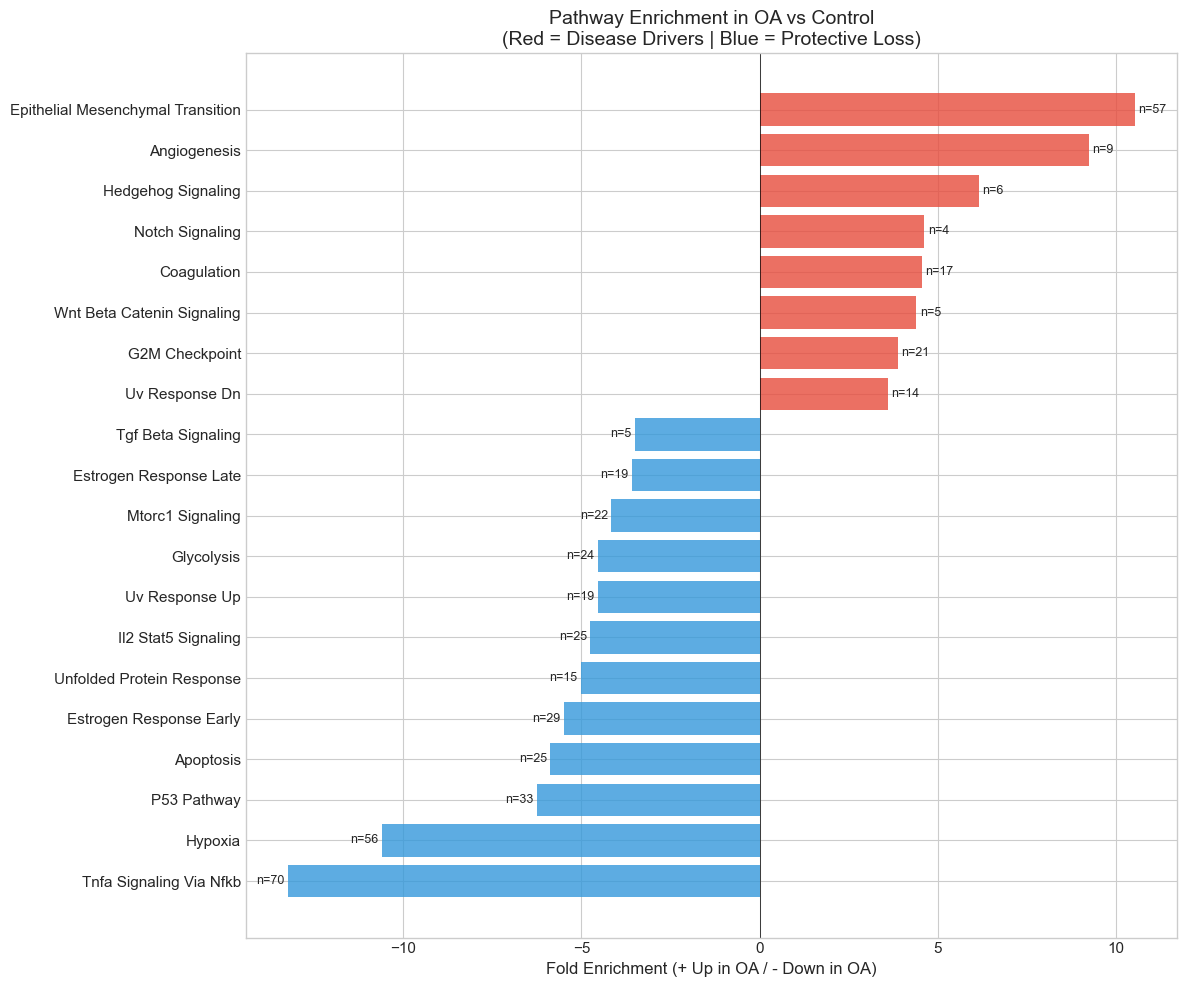


✅ Cell 6 complete. Ready for Cell 7.


In [6]:
"""
CELL 6: PATHWAY ENRICHMENT VISUALIZATION
========================================
Create publication-quality enrichment plot.
"""

print("📊 GENERATING PATHWAY ENRICHMENT PLOT")
print("="*70)
print()

# Select significant pathways for plotting
sig_pathways = enrichment_df[
    (enrichment_df['FDR_up'] < 0.05) | (enrichment_df['FDR_down'] < 0.05)
].copy()

if len(sig_pathways) > 0:
    # Create signed enrichment score (positive = up, negative = down)
    sig_pathways['signed_score'] = sig_pathways.apply(
        lambda row: row['fold_enrichment_up'] if row['fold_enrichment_up'] > row['fold_enrichment_down']
                    else -row['fold_enrichment_down'],
        axis=1
    )
    
    # Take top 20 by absolute score
    sig_pathways['abs_score'] = sig_pathways['signed_score'].abs()
    plot_df = sig_pathways.nlargest(20, 'abs_score').copy()
    plot_df['clean_name'] = plot_df['pathway'].apply(clean_pathway_name)
    plot_df = plot_df.sort_values('signed_score')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Colors: red for up, blue for down
    colors = ['#e74c3c' if x > 0 else '#3498db' for x in plot_df['signed_score']]
    
    # Horizontal bar plot
    bars = ax.barh(range(len(plot_df)), plot_df['signed_score'], color=colors, alpha=0.8)
    
    # Add pathway names
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df['clean_name'])
    
    # Labels and title
    ax.set_xlabel('Fold Enrichment (+ Up in OA / - Down in OA)', fontsize=12)
    ax.set_title('Pathway Enrichment in OA vs Control\n(Red = Disease Drivers | Blue = Protective Loss)', fontsize=14)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add gene counts
    for i, (idx, row) in enumerate(plot_df.iterrows()):
        n_genes = row['n_up_overlap'] if row['signed_score'] > 0 else row['n_down_overlap']
        x_pos = row['signed_score'] + (0.1 if row['signed_score'] > 0 else -0.1)
        ax.text(x_pos, i, f"n={n_genes}", va='center', ha='left' if row['signed_score'] > 0 else 'right', fontsize=9)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = FIGURES_DIR / 'pathway_enrichment_barplot.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"   💾 Saved: {fig_path}")
    
    plt.show()
else:
    print("   ⚠️ No significantly enriched pathways found")

print()
print("✅ Cell 6 complete. Ready for Cell 7.")

---
## Cell 7: Map to Aging Hallmarks

In [7]:
"""
CELL 7: MAP TO AGING HALLMARKS (Simplified)
===========================================
Bridge disease biology to aging biology.
APPROACH: Count significant pathways per hallmark + identify top contributor.
This is more transparent and investor-friendly than complex weighted scores.
"""

# Define utility function (also in Cell 5, but redefined here for robustness)
def clean_pathway_name(name):
    return name.replace('HALLMARK_', '').replace('_', ' ').title()

print("🧬 MAPPING TO AGING HALLMARKS")
print("="*70)
print()
print("🎯 This bridges: Disease Dysregulation → Aging Biology → Intervention Targets")
print()
print("📐 Method: Count significant pathways (FDR < 0.05) per aging hallmark")
print()

# Calculate aging hallmark scores using SIMPLE COUNTS
aging_scores = []

for aging_hallmark, pathways in AGING_HALLMARK_MAPPING.items():
    count_sig_up = 0
    count_sig_down = 0
    top_up_pathway = None
    top_up_fe = 0
    top_down_pathway = None
    top_down_fe = 0
    up_genes_all = set()
    down_genes_all = set()
    
    for pathway in pathways:
        if pathway in enrichment_df['pathway'].values:
            row = enrichment_df[enrichment_df['pathway'] == pathway].iloc[0]
            
            # Count significant UP pathways and track top contributor
            if row['FDR_up'] < 0.05:
                count_sig_up += 1
                if row['up_genes']:
                    up_genes_all.update(row['up_genes'].split(','))
                if row['fold_enrichment_up'] > top_up_fe:
                    top_up_fe = row['fold_enrichment_up']
                    top_up_pathway = clean_pathway_name(pathway)
            
            # Count significant DOWN pathways and track top contributor
            if row['FDR_down'] < 0.05:
                count_sig_down += 1
                if row['down_genes']:
                    down_genes_all.update(row['down_genes'].split(','))
                if row['fold_enrichment_down'] > top_down_fe:
                    top_down_fe = row['fold_enrichment_down']
                    top_down_pathway = clean_pathway_name(pathway)
    
    # Determine dominant direction based on counts
    if count_sig_up > count_sig_down:
        net_direction = 'Disease-elevated'
        intervention = 'TARGET FOR INHIBITION'
        top_pathway = top_up_pathway
    elif count_sig_down > count_sig_up:
        net_direction = 'Loss of protective signaling'
        intervention = 'TARGET FOR RESTORATION'
        top_pathway = top_down_pathway
    elif count_sig_up > 0 and count_sig_up == count_sig_down:
        net_direction = 'Mixed signal'
        intervention = 'Context-dependent'
        top_pathway = top_up_pathway or top_down_pathway
    else:
        net_direction = 'Not significant'
        intervention = 'Not prioritized'
        top_pathway = 'N/A'
    
    aging_scores.append({
        'aging_hallmark': aging_hallmark,
        'n_pathways_mapped': len(pathways),
        'count_sig_up': count_sig_up,
        'count_sig_down': count_sig_down,
        'direction': net_direction,
        'intervention_strategy': intervention,
        'top_contributing_pathway': top_pathway if top_pathway else 'N/A',
        'top_up_fold_enrichment': round(top_up_fe, 2) if top_up_fe > 0 else None,
        'top_down_fold_enrichment': round(top_down_fe, 2) if top_down_fe > 0 else None,
        'n_up_genes': len(up_genes_all),
        'n_down_genes': len(down_genes_all),
        'top_up_genes': ','.join(sorted(up_genes_all)[:10]),
        'top_down_genes': ','.join(sorted(down_genes_all)[:10]),
        # Legacy columns for backward compatibility
        'mean_up_enrichment': count_sig_up,
        'mean_down_enrichment': count_sig_down,
        'net_score': count_sig_up - count_sig_down,
    })

aging_hallmark_df = pd.DataFrame(aging_scores)
aging_hallmark_df = aging_hallmark_df.sort_values('net_score', key=abs, ascending=False)

# Display results
print("📋 AGING HALLMARK IMPACT SUMMARY")
print("-"*90)
print(f"{'Aging Hallmark':<35} {'Up':>7} {'Down':>7} {'Direction':<28} {'Top Pathway':<25}")
print("-"*90)

for _, row in aging_hallmark_df.iterrows():
    print(f"{row['aging_hallmark']:<35} {row['count_sig_up']:>7} {row['count_sig_down']:>7} {row['direction']:<28} {row['top_contributing_pathway']:<25}")

print()
print("✅ Cell 7 complete. Ready for Cell 8.")


🧬 MAPPING TO AGING HALLMARKS

🎯 This bridges: Disease Dysregulation → Aging Biology → Intervention Targets

📐 Method: Count significant pathways (FDR < 0.05) per aging hallmark

📋 AGING HALLMARK IMPACT SUMMARY
------------------------------------------------------------------------------------------
Aging Hallmark                           Up    Down Direction                    Top Pathway              
------------------------------------------------------------------------------------------
Chronic Inflammation (Inflammaging)       2       4 Loss of protective signaling Tnfa Signaling Via Nfkb  
Loss of Proteostasis                      0       2 Loss of protective signaling Unfolded Protein Response
Altered Metabolism                        2       4 Loss of protective signaling Hypoxia                  
ECM Degradation & Fibrosis                3       2 Disease-elevated             Epithelial Mesenchymal Transition
Stem Cell Exhaustion                      4       3 Disease-eleva

---
## Cell 8: Aging Hallmark Heatmap

📊 GENERATING AGING HALLMARK HEATMAP

   💾 Saved: C:\Users\povan\Kairos_Therapeutics\reports\figures\aging_hallmark_heatmap.png


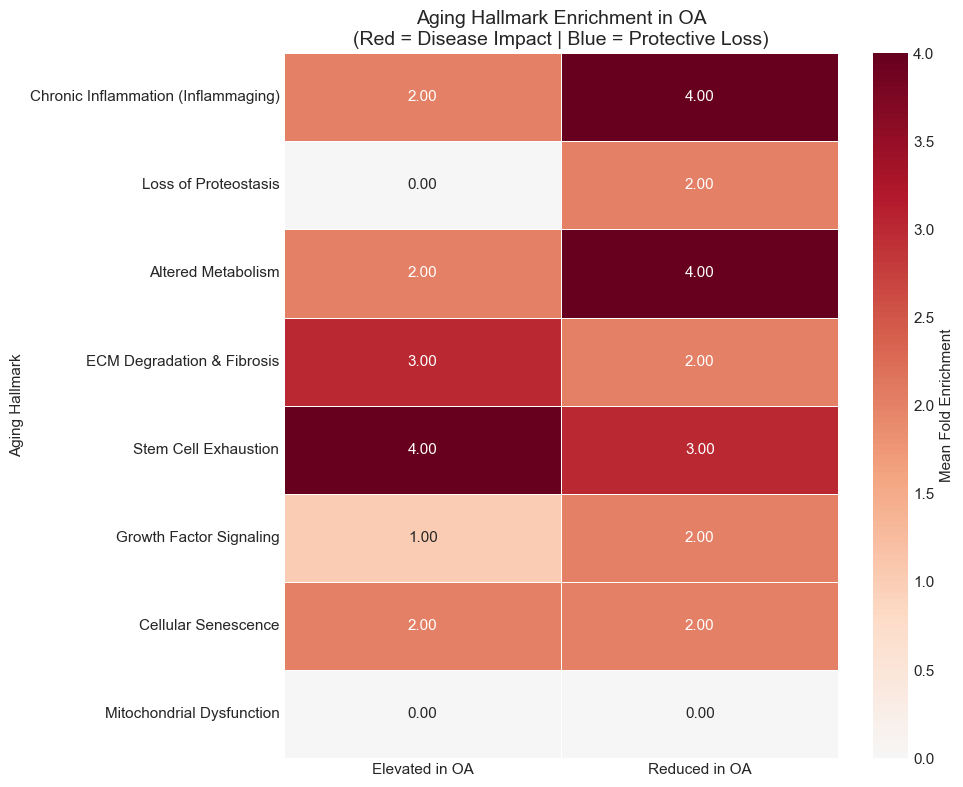


✅ Cell 8 complete. Ready for Cell 9.


In [8]:
"""
CELL 8: AGING HALLMARK HEATMAP
==============================
Visualize aging hallmark enrichment for investor presentation.
"""

print("📊 GENERATING AGING HALLMARK HEATMAP")
print("="*70)
print()

# Prepare data for heatmap
heatmap_data = aging_hallmark_df.set_index('aging_hallmark')[['mean_up_enrichment', 'mean_down_enrichment']].copy()
heatmap_data.columns = ['Elevated in OA', 'Reduced in OA']

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean Fold Enrichment'},
    ax=ax
)

ax.set_title('Aging Hallmark Enrichment in OA\n(Red = Disease Impact | Blue = Protective Loss)', fontsize=14)
ax.set_ylabel('Aging Hallmark')
ax.set_xlabel('')

plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'aging_hallmark_heatmap.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"   💾 Saved: {fig_path}")

plt.show()

print()
print("✅ Cell 8 complete. Ready for Cell 9.")

---
## Cell 9: Gene-Pathway-Hallmark Mapping

In [9]:
"""
CELL 9: GENE-PATHWAY-HALLMARK MAPPING
=====================================
Create detailed mapping: Gene → Pathway → Aging Hallmark
This enables tracing from individual genes to therapeutic relevance.
"""

print("🔗 CREATING GENE-PATHWAY-HALLMARK MAPPING")
print("="*70)
print()

# Create mapping
gene_mapping = []

for _, gene_row in sig_genes.iterrows():
    gene = gene_row['gene']
    gene_direction = gene_row['significance']
    log2fc = gene_row['log2FC']
    
    # Find which pathways contain this gene
    for pathway_name, pathway_genes in hallmark_sets.items():
        if gene in pathway_genes:
            # Find aging hallmark category
            aging_category = 'Other'
            for ah, pathways in AGING_HALLMARK_MAPPING.items():
                if pathway_name in pathways:
                    aging_category = ah
                    break
            
            gene_mapping.append({
                'gene': gene,
                'log2FC': log2fc,
                'direction': gene_direction,
                'pathway': pathway_name,
                'pathway_clean': clean_pathway_name(pathway_name),
                'aging_hallmark': aging_category,
            })

gene_mapping_df = pd.DataFrame(gene_mapping)

print(f"   ✅ Created mapping for {gene_mapping_df['gene'].nunique()} genes")
print(f"   ✅ Across {gene_mapping_df['pathway'].nunique()} pathways")
print(f"   ✅ Linked to {gene_mapping_df['aging_hallmark'].nunique()} aging hallmarks")
print()

# Show example mapping
print("📋 EXAMPLE MAPPING (Top DE genes):")
print("-"*70)

top_genes_to_show = ['MMP13', 'COL1A1', 'SOX9', 'ADAMTS5', 'POSTN']
for gene in top_genes_to_show:
    gene_data = gene_mapping_df[gene_mapping_df['gene'] == gene]
    if len(gene_data) > 0:
        fc = gene_data['log2FC'].iloc[0]
        direction = gene_data['direction'].iloc[0]
        hallmarks = gene_data['aging_hallmark'].unique()[:3]
        pathways = gene_data['pathway_clean'].unique()[:3]
        print(f"   {gene} ({direction}, log2FC={fc:.2f})")
        print(f"      Pathways: {', '.join(pathways)}")
        print(f"      Aging: {', '.join(hallmarks)}")
        print()

print("✅ Cell 9 complete. Ready for Cell 10.")

🔗 CREATING GENE-PATHWAY-HALLMARK MAPPING

   ✅ Created mapping for 479 genes
   ✅ Across 50 pathways
   ✅ Linked to 9 aging hallmarks

📋 EXAMPLE MAPPING (Top DE genes):
----------------------------------------------------------------------
   MMP13 (Up in OA, log2FC=3.20)
      Pathways: Complement
      Aging: Chronic Inflammation (Inflammaging)

   COL1A1 (Up in OA, log2FC=5.17)
      Pathways: Epithelial Mesenchymal Transition, Myogenesis, Uv Response Dn
      Aging: ECM Degradation & Fibrosis, Stem Cell Exhaustion, Other

   SOX9 (Down in OA, log2FC=-2.07)
      Pathways: Glycolysis, Kras Signaling Up
      Aging: Altered Metabolism, Growth Factor Signaling

   ADAMTS5 (Up in OA, log2FC=1.93)
      Pathways: Apical Junction
      Aging: Other

   POSTN (Up in OA, log2FC=5.92)
      Pathways: Angiogenesis, Epithelial Mesenchymal Transition
      Aging: ECM Degradation & Fibrosis

✅ Cell 9 complete. Ready for Cell 10.


---
## Cell 10: Intervention Candidate Summary

In [10]:
"""
CELL 10: INTERVENTION CANDIDATE SUMMARY
=======================================
Identify top intervention targets by combining:
1. DE significance
2. Pathway membership
3. Aging hallmark relevance

Framing: What genes should be UP/DOWN regulated to reverse disease?
"""

print("🎯 INTERVENTION CANDIDATE SUMMARY")
print("="*70)
print()
print("Strategic Question: What gene perturbations move OA → Healthy?")
print()

# Count pathway/hallmark memberships per gene
gene_scores = gene_mapping_df.groupby('gene').agg({
    'log2FC': 'first',
    'direction': 'first',
    'pathway': 'nunique',
    'aging_hallmark': lambda x: ', '.join(x.unique()[:3]),
}).rename(columns={'pathway': 'n_pathways'})

# Add intervention strategy
gene_scores['intervention'] = gene_scores['direction'].apply(
    lambda x: 'INHIBIT (reduce expression)' if x == 'Up in OA' else 'RESTORE (increase expression)'
)

# Merge with full DE results for FDR
gene_scores = gene_scores.reset_index()
gene_scores = gene_scores.merge(
    de_results[['gene', 'FDR', 'mean_OA', 'mean_Control']],
    on='gene',
    how='left'
)

# Sort by pathway count and significance
gene_scores['priority_score'] = gene_scores['n_pathways'] * -np.log10(gene_scores['FDR'].clip(lower=1e-50))
gene_scores = gene_scores.sort_values('priority_score', ascending=False)

# Top targets to INHIBIT (up in OA)
print("🔴 TOP TARGETS TO INHIBIT (Upregulated Disease Drivers)")
print("-"*70)
print(f"{'Gene':<12} {'log2FC':>8} {'Pathways':>10} {'Aging Hallmarks':<35}")
print("-"*70)
inhibit_targets = gene_scores[gene_scores['direction'] == 'Up in OA'].head(15)
for _, row in inhibit_targets.iterrows():
    print(f"{row['gene']:<12} {row['log2FC']:>8.2f} {row['n_pathways']:>10} {row['aging_hallmark']:<35}")

print()
print("🔵 TOP TARGETS TO RESTORE (Downregulated Protective Factors)")
print("-"*70)
print(f"{'Gene':<12} {'log2FC':>8} {'Pathways':>10} {'Aging Hallmarks':<35}")
print("-"*70)
restore_targets = gene_scores[gene_scores['direction'] == 'Down in OA'].head(15)
for _, row in restore_targets.iterrows():
    print(f"{row['gene']:<12} {row['log2FC']:>8.2f} {row['n_pathways']:>10} {row['aging_hallmark']:<35}")

print()
print("✅ Cell 10 complete. Ready for Cell 11.")

🎯 INTERVENTION CANDIDATE SUMMARY

Strategic Question: What gene perturbations move OA → Healthy?

🔴 TOP TARGETS TO INHIBIT (Upregulated Disease Drivers)
----------------------------------------------------------------------
Gene           log2FC   Pathways Aging Hallmarks                    
----------------------------------------------------------------------
CCND1            2.03          7 Other, Cellular Senescence, Stem Cell Exhaustion
THY1             3.94          5 Chronic Inflammation (Inflammaging), Other, ECM Degradation & Fibrosis
IGFBP3           2.96          5 ECM Degradation & Fibrosis, Altered Metabolism, Growth Factor Signaling
TOP2A            2.58          6 Cellular Senescence, Other         
TGFBI            4.02          4 Other, ECM Degradation & Fibrosis, Altered Metabolism
COL1A1           5.17          3 ECM Degradation & Fibrosis, Stem Cell Exhaustion, Other
TNFAIP6          4.09          3 Chronic Inflammation (Inflammaging)
CDK1             1.18          

---
## Cell 11: Save Results

In [11]:
"""
CELL 11: SAVE RESULTS
=====================
Export all results for downstream analysis.
"""

print("💾 SAVING RESULTS")
print("="*70)
print()

# Save pathway enrichment results
enrichment_path = DATA_PROCESSED / 'pathway_enrichment_results.csv'
enrichment_df.to_csv(enrichment_path, index=False)
print(f"   ✅ Pathway enrichment: {enrichment_path}")

# Save aging hallmark mapping
aging_path = DATA_PROCESSED / 'aging_hallmark_mapping.csv'
aging_hallmark_df.to_csv(aging_path, index=False)
print(f"   ✅ Aging hallmark summary: {aging_path}")

# Save gene-pathway-hallmark mapping
gene_map_path = DATA_PROCESSED / 'gene_pathway_hallmark_mapping.csv'
gene_mapping_df.to_csv(gene_map_path, index=False)
print(f"   ✅ Gene-pathway-hallmark mapping: {gene_map_path}")

# Save intervention candidates
intervention_path = DATA_PROCESSED / 'intervention_candidates.csv'
gene_scores.to_csv(intervention_path, index=False)
print(f"   ✅ Intervention candidates: {intervention_path}")

print()
print("✅ Cell 11 complete. Ready for Cell 12.")

💾 SAVING RESULTS

   ✅ Pathway enrichment: C:\Users\povan\Kairos_Therapeutics\data\processed\pathway_enrichment_results.csv
   ✅ Aging hallmark summary: C:\Users\povan\Kairos_Therapeutics\data\processed\aging_hallmark_mapping.csv
   ✅ Gene-pathway-hallmark mapping: C:\Users\povan\Kairos_Therapeutics\data\processed\gene_pathway_hallmark_mapping.csv
   ✅ Intervention candidates: C:\Users\povan\Kairos_Therapeutics\data\processed\intervention_candidates.csv

✅ Cell 11 complete. Ready for Cell 12.


---
## Cell 12: Summary Report

In [12]:
"""
CELL 12: SUMMARY REPORT
=======================
Generate comprehensive report bridging disease to aging biology.
"""

print("📝 GENERATING SUMMARY REPORT")
print("="*70)
print()

report_lines = []
report_lines.append("="*70)
report_lines.append("KAIROS ML PROTOTYPE V0 - PATHWAY & AGING HALLMARK ENRICHMENT")
report_lines.append("Dataset: GSE114007 (Knee Cartilage OA vs Control)")
report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append("="*70)
report_lines.append("")

report_lines.append("STRATEGIC CONTEXT")
report_lines.append("-"*40)
report_lines.append("Kairos Therapeutics: Causal gene-intervention discovery for aging biology")
report_lines.append("This analysis bridges: Disease → Aging Biology → Intervention Targets")
report_lines.append("")

report_lines.append("PATHWAY ENRICHMENT SUMMARY")
report_lines.append("-"*40)
report_lines.append(f"Total pathways analyzed: {len(enrichment_df)}")
report_lines.append(f"Pathways enriched in UPREGULATED genes: {(enrichment_df['FDR_up'] < 0.05).sum()}")
report_lines.append(f"Pathways enriched in DOWNREGULATED genes: {(enrichment_df['FDR_down'] < 0.05).sum()}")
report_lines.append("")

report_lines.append("TOP UPREGULATED PATHWAYS (Disease Drivers)")
report_lines.append("-"*40)
for _, row in top_up.head(5).iterrows():
    name = clean_pathway_name(row['pathway'])
    report_lines.append(f"  {name}: {row['n_up_overlap']} genes, FE={row['fold_enrichment_up']:.2f}")
report_lines.append("")

report_lines.append("TOP DOWNREGULATED PATHWAYS (Protective Loss)")
report_lines.append("-"*40)
for _, row in top_down.head(5).iterrows():
    name = clean_pathway_name(row['pathway'])
    report_lines.append(f"  {name}: {row['n_down_overlap']} genes, FE={row['fold_enrichment_down']:.2f}")
report_lines.append("")

report_lines.append("AGING HALLMARK IMPACT")
report_lines.append("-"*40)
for _, row in aging_hallmark_df.iterrows():
    report_lines.append(f"  {row['aging_hallmark']}: {row['direction']} → {row['intervention_strategy']}")
report_lines.append("")

report_lines.append("OUTPUT FILES")
report_lines.append("-"*40)
report_lines.append("  pathway_enrichment_results.csv")
report_lines.append("  aging_hallmark_mapping.csv")
report_lines.append("  gene_pathway_hallmark_mapping.csv")
report_lines.append("  intervention_candidates.csv")
report_lines.append("  pathway_enrichment_barplot.png")
report_lines.append("  aging_hallmark_heatmap.png")
report_lines.append("")

report_lines.append("NEXT STEPS")
report_lines.append("-"*40)
report_lines.append("  1. Notebook 05: Age-Disease Intersection Analysis")
report_lines.append("  2. Notebook 06: Therapeutic Target Prioritization")
report_lines.append("  3. Filter for secreted factors (MSC-deliverable)")
report_lines.append("  4. Build Streamlit demo for investors")
report_lines.append("")
report_lines.append("="*70)

# Print and save
report_text = "\n".join(report_lines)
print(report_text)

report_path = REPORTS_DIR / 'pathway_enrichment_summary.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_text)
print()
print(f"💾 Report saved: {report_path}")

print()
print("✅ Cell 12 complete. Notebook 04 finished!")

📝 GENERATING SUMMARY REPORT

KAIROS ML PROTOTYPE V0 - PATHWAY & AGING HALLMARK ENRICHMENT
Dataset: GSE114007 (Knee Cartilage OA vs Control)
Generated: 2025-12-26 20:52:39

STRATEGIC CONTEXT
----------------------------------------
Kairos Therapeutics: Causal gene-intervention discovery for aging biology
This analysis bridges: Disease → Aging Biology → Intervention Targets

PATHWAY ENRICHMENT SUMMARY
----------------------------------------
Total pathways analyzed: 50
Pathways enriched in UPREGULATED genes: 19
Pathways enriched in DOWNREGULATED genes: 25

TOP UPREGULATED PATHWAYS (Disease Drivers)
----------------------------------------
  Epithelial Mesenchymal Transition: 57 genes, FE=10.53
  Angiogenesis: 9 genes, FE=9.23
  Hedgehog Signaling: 6 genes, FE=6.16
  Notch Signaling: 4 genes, FE=4.62
  Coagulation: 17 genes, FE=4.55

TOP DOWNREGULATED PATHWAYS (Protective Loss)
----------------------------------------
  Tnfa Signaling Via Nfkb: 70 genes, FE=13.24
  Hypoxia: 56 genes, FE=1

---
## Cell 13: Final Checkpoint

In [14]:
"""
CELL 13: FINAL CHECKPOINT
=========================
Summary and next steps.
"""

print("="*70)
print("🎯 NOTEBOOK 04 COMPLETE - FINAL CHECKPOINT")
print("="*70)
print()

print("📊 KEY FINDINGS:")
print("-"*40)
print(f"   Total pathways analyzed: {len(enrichment_df)}")
print(f"   Significant UP pathways: {(enrichment_df['FDR_up'] < 0.05).sum()}")
print(f"   Significant DOWN pathways: {(enrichment_df['FDR_down'] < 0.05).sum()}")
print(f"   Genes mapped to pathways: {gene_mapping_df['gene'].nunique()}")
print(f"   Intervention candidates: {len(gene_scores)}")

print()
print("🧬 AGING HALLMARKS IMPACTED:")
print("-"*40)
for _, row in aging_hallmark_df[aging_hallmark_df['net_score'] != 0].iterrows():
    print(f"   • {row['aging_hallmark']}: {row['direction']}")

print()
print("📁 OUTPUT FILES:")
print("-"*40)
output_files = [
    DATA_PROCESSED / 'pathway_enrichment_results.csv',
    DATA_PROCESSED / 'aging_hallmark_mapping.csv',
    DATA_PROCESSED / 'intervention_candidates.csv',
    FIGURES_DIR / 'pathway_enrichment_barplot.png',
    FIGURES_DIR / 'aging_hallmark_heatmap.png',
]
for f in output_files:
    if f.exists():
        size_kb = f.stat().st_size / 1024
        print(f"   ✅ {f.name} ({size_kb:.1f} KB)")

print()
print("🚀 NEXT STEPS:")
print("-"*40)
print("   1. Commit this notebook to GitHub")
print("   2. Notebook 05: Age-Disease Intersection Analysis")
print("   3. Notebook 06: Therapeutic Target Prioritization")

print()
print("📋 GIT COMMANDS:")
print("-"*40)
print('   git add notebooks/Notebook_04_Pathway_and_Aging_Enrichment.ipynb')
print('   git add reports/')
print('   git commit -m "Add Notebook 04: Pathway & Aging Hallmark Enrichment"')
print('   git push origin main')

print()
print(f"🕐 Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

🎯 NOTEBOOK 04 COMPLETE - FINAL CHECKPOINT

📊 KEY FINDINGS:
----------------------------------------
   Total pathways analyzed: 50
   Significant UP pathways: 19
   Significant DOWN pathways: 25
   Genes mapped to pathways: 479
   Intervention candidates: 479

🧬 AGING HALLMARKS IMPACTED:
----------------------------------------
   • ECM Degradation & Fibrosis: ELEVATED in OA
   • Chronic Inflammation (Inflammaging): REDUCED in OA
   • Cellular Senescence: REDUCED in OA
   • Altered Metabolism: REDUCED in OA
   • Loss of Proteostasis: REDUCED in OA
   • Stem Cell Exhaustion: ELEVATED in OA
   • Growth Factor Signaling: REDUCED in OA

📁 OUTPUT FILES:
----------------------------------------
   ✅ pathway_enrichment_results.csv (16.2 KB)
   ✅ aging_hallmark_mapping.csv (1.8 KB)
   ✅ intervention_candidates.csv (81.5 KB)
   ✅ pathway_enrichment_barplot.png (124.1 KB)
   ✅ aging_hallmark_heatmap.png (91.0 KB)

🚀 NEXT STEPS:
----------------------------------------
   1. Commit this notebook 

---
## End of Notebook 04

**Summary:**
- Performed pathway enrichment analysis using MSigDB Hallmarks
- Mapped pathways to biological aging hallmarks
- Created gene → pathway → aging hallmark linkages
- Identified intervention candidates with clear direction (inhibit vs restore)

**Strategic Achievement:**
- Successfully bridged disease biology → aging biology
- Framed all outputs as intervention opportunities
- Created foundation for therapeutic target prioritization

**Next:** Notebook 05 - Age-Disease Intersection Analysis